My goal is to build a model for the inference we are trying to perform. To reiterate, my goal is to build a model that infers both the dark matter mass of each individual cluster and the global DMM/richness relation. This model will be constrained with simulation data, which will give us the richness and redshift of a galaxy cluster. 

The DMM/Richness relation is assumed to be of the form:

$\lambda = aM^b+\sigma$ 

Where $a,b$ are free parameters and $\sigma$ is some scatter. I'll sketch a PGM of this model below. 

At this moment, I'm confused as to how the richness and redshift alone can constrain individual masses. I will try to talk to Matt Becker tomorrow about it. I spoke to Joe for a minute at my desk about it, and he thinks it's possible that, given a mass function it is possible to constrain mass with lambda and redshift (sorta?). I'm still not 100% sure about it. 

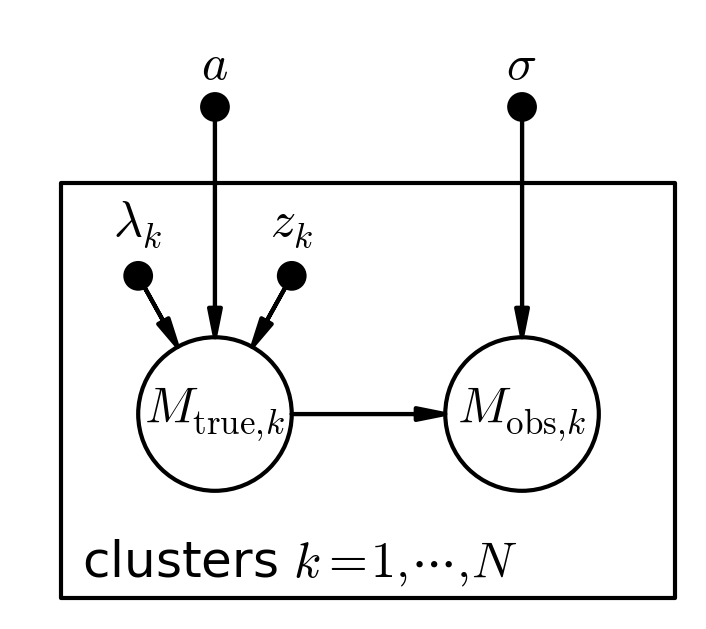

In [2]:
import daft

pgm = daft.PGM([2.3, 2.05], origin=[.3,.3], grid_unit = 2.6, node_unit=1.3, observed_style="inner")

pgm.add_node(daft.Node("a", r"$a$", 1,2,fixed =True))
pgm.add_node(daft.Node("scatter", r"$\sigma$", 2, 2, fixed = True))

pgm.add_node(daft.Node("richness", r"$\lambda_k$", .75,1.45,fixed =True))
pgm.add_node(daft.Node("redshift", r"$z_k$", 1.25,1.45,fixed =True))

pgm.add_node(daft.Node("Mtrue", r"$M_{{\rm true},k}$", 1,1))

pgm.add_node(daft.Node("Mobs", r"$M_{{\rm obs},k}$", 2,1))

pgm.add_edge("a", "Mtrue")
pgm.add_edge("richness", "Mtrue")
pgm.add_edge("redshift", "Mtrue")
pgm.add_edge("Mtrue", "Mobs")
pgm.add_edge("scatter", "Mobs")

pgm.add_plate(daft.Plate([.5,.5,2,1.25], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render()
pgm.figure.savefig("modelPGM.png", dpi = 300)
from IPython.display import Image
Image("modelPGM.png")